### Camera Calibration

No of Images 20
Camera Calibration Done!


{'dist': array([[ -2.41017968e-01,  -5.30720497e-02,  -1.15810318e-03,
          -1.28318543e-04,   2.67124302e-02]]),
 'mtx': array([[  1.15396093e+03,   0.00000000e+00,   6.69705359e+02],
        [  0.00000000e+00,   1.14802495e+03,   3.85656232e+02],
        [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]])}

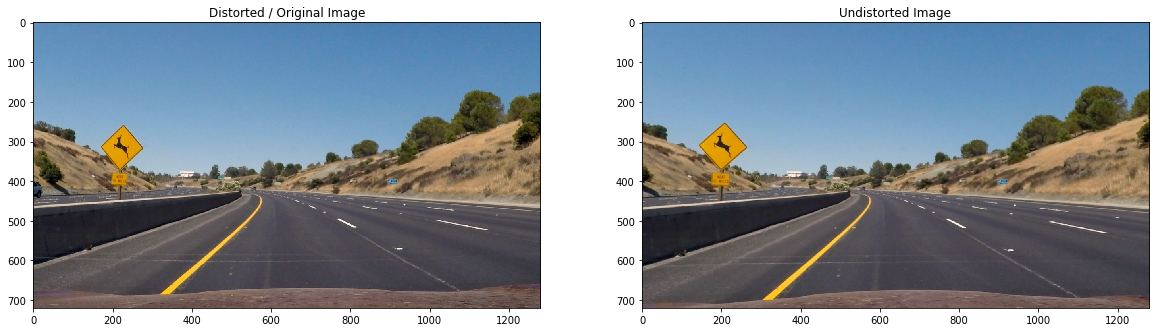

In [7]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
import pickle
%matplotlib inline

#Camera Calibration
def calibrate_camera():
    img_names = glob.glob('camera_cal/calibration*.jpg')
    print('No of Images {}'.format(len(img_names)))

    #Image points are the coordinates for image and Object points are coordinates for undistored 3D image
    objpoints = [] #3D with 3rd co-or always 0 since it is a plane
    imgpoints = [] #2D
    
    #Our board has x = 9 (0 - 8), y = 6 (0 - 5). If assuming corner right intersetction as (0, 0, 0), you'll have 9 * 6 intersections
    objp = np.zeros((9*6, 3), np.float32)

    """
    Generate coordinates for X, Y using mpgrid (assuming each box is 1*1 length)
    Z coordinate is 0, no need to populate it
    [:, :2] means all 9*6 values for 0th and 1st array, leaving 2nd which is for Z coordinate
    Reshape to 2 columns
    """
    objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)
    for img_name, i in zip(img_names, range(len(img_names))):

        #To create the image points, Look at the distorted image and use cv2(on gray scale) and detect corners
        img = cv2.imread(img_name)
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        ret, corners = cv2.findChessboardCorners(img_gray, (9, 6), None)
        #print('{}. Return value for Image {} --> {}'.format(i+1, img_name, ret))
        #If the function detects corners, then append those to image points
        if ret:
            imgpoints.append(corners)
            objpoints.append(objp) #This is printing correctly
            #draw detected corners
            #img_draw = cv2.drawChessboardCorners(img, (8, 6), corners, ret)
            
    #Saving to a pickle
    img = cv2.imread('test_images/test2.jpg')
    shape = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, shape, None, None)
    undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)
    print('Camera Calibration Done!')
    #Plotting
    fig, axs = plt.subplots(1,2, figsize=(20, 10))
    axs[0].set_title('Distorted / Original Image')
    axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[1].set_title('Undistorted Image')
    axs[1].imshow(cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB))

    dist_pickle = {}
    dist_pickle['mtx'] = mtx
    dist_pickle['dist'] = dist
    pickle.dump(dist_pickle, open("data/calibration_pickle.p", 'wb'))
    
    
    return dist_pickle

calibrate_camera()


Shapes Sobel (720, 1280) S Channel (720, 1280) Combined Binary (720, 1280) DStack (720, 1280, 3)


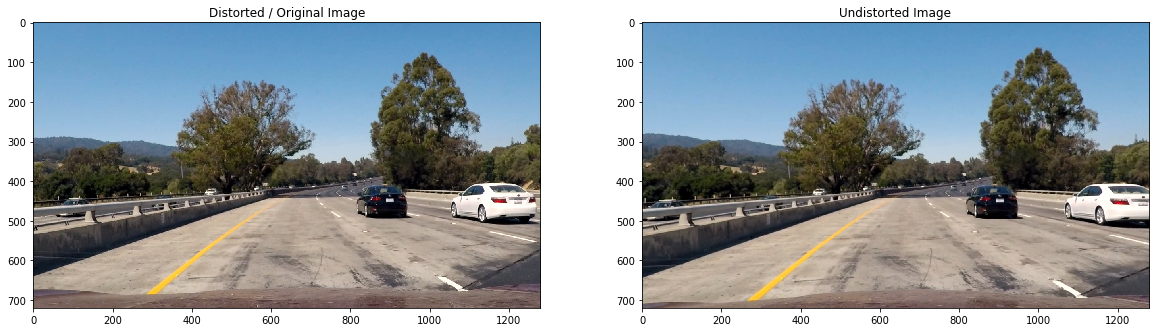

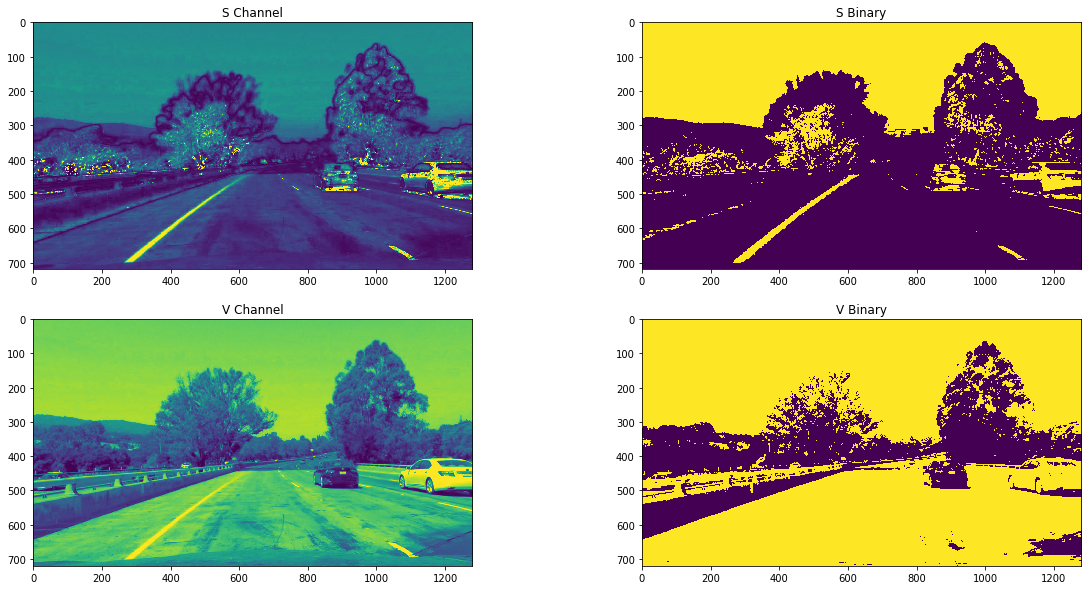

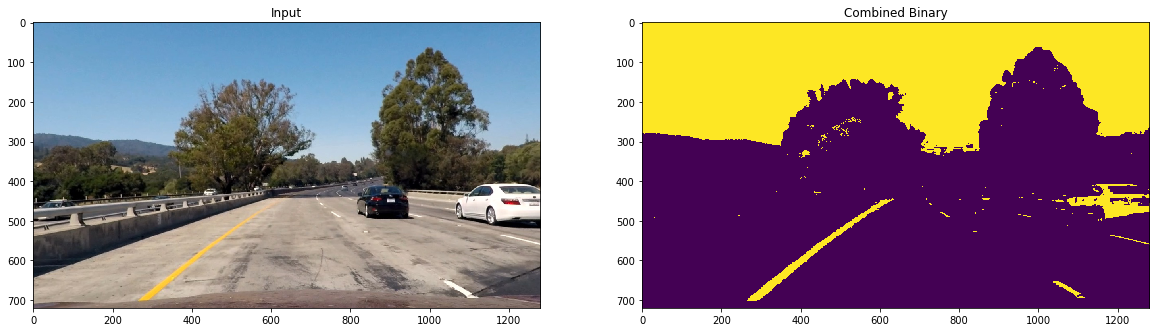

In [30]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
import pickle
%matplotlib inline

#Loading pickle
def load_pickle():
    dist_pickle = pickle.load( open('data/calibration_pickle.p', 'rb'))
    mtx = dist_pickle['mtx']
    dist = dist_pickle['dist']
    return mtx, dist

#Perspective Transformation
def warp_image(img, src, dst):
    #Perspective tranform, M
    M = cv2.getPerspectiveTransform(src, dst)

    #Inverse Perspective transform
    Minv = cv2.getPerspectiveTransform(dst, src)

    img_size = (img.shape[1], img.shape[0])
    #warped image - uses linear interpolation
    warped_img = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped_img

def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    """
    Determine sobel for x or y
    Absolute soble
    uint8
    binary
    """
    img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        #print('inside x')
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0)
        abs_sobel = np.absolute(sobel)
    else:
        #print('inside y')
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1)
        abs_sobel = np.absolute(sobel)
        
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    img_binary = np.zeros_like(scaled_sobel)
    img_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return img_binary



def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    """
    Determine sobelx and sobely
    sqrt(x**2 + y**2)
    uint8
    binary
    """
    img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    sobel_mag = np.sqrt(sobelx**2 + sobely**2)

    #scaled_sobel = np.uint8(255*sobel_mag/np.max(sobel_mag))
    scale_factor = np.max(sobel_mag)*255
    scaled_sobel = (sobel_mag/scale_factor).astype(np.uint8)
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    """
    Determine sobelx and sobely
    Absolute
    arctan2(y, x)
    binary
    """
    img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    sobely = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    dir_sobel = np.arctan2(sobely, sobelx)
    dir_binary = np.zeros_like(dir_sobel)
    dir_binary[(dir_sobel >= thresh[0]) & (dir_sobel <= thresh[1])] = 1
    return dir_binary

def color_threshold(img, sthresh=(0, 255), vthresh=(0, 255)):
    img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = img_hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= sthresh[0]) & (s_channel <= sthresh[1])] = 1
    
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    v_channel = img_hsv[:,:,2]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= vthresh[0]) & (v_channel <= vthresh[1])] = 1

    #Plotting
#     fig, axs = plt.subplots(2,2, figsize=(20, 10))
#     axs[0,0].set_title('S Channel')
#     axs[0,0].imshow(s_channel)
#     axs[0,1].set_title('S Output')
#     axs[0,1].imshow(s_binary)
#     axs[1,0].set_title('V Channel')
#     axs[1,0].imshow(v_channel)
#     axs[1,1].set_title('V Output')
#     axs[1,1].imshow(v_binary)
    
    output = np.zeros_like(s_channel)
    output[(s_binary == 1) & (v_binary == 1)] = 1
    
#     fig, axs = plt.subplots(1,2, figsize=(20, 10))
#     axs[0].set_title('Input')
#     axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#     axs[1].set_title('Combined Binary')
#     axs[1].imshow(output)
    
    return output

# def window_mask(widht, height, img_ref, center, level):
#     mask = np.zeros_like(img_ref)
#     mask[]
######################################################################################
#Undistorting
mtx, dist = load_pickle()
img = cv2.imread('test_images/test1.jpg')
undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)

#Plotting
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.set_title('Distorted / Original Image')
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted Image')
ax2.imshow(cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB))

#Thresholding
sobelx = abs_sobel_thresh(undistorted_img, 'x', 3, (12,255))
sobely = abs_sobel_thresh(undistorted_img, 'y', 3, (25,255))

sv_channel = color_threshold(undistorted_img, (90, 255), (90, 255))

combined_binary = np.zeros_like(sobelx)
combined_binary[(sobelx == 1 ) | (sobely == 1 ) | (sv_channel == 1)] = 1

color_stack = np.dstack(( np.zeros_like(sobelx), sobelx, sv_channel)) * 255
print('Shapes Sobel {} S Channel {} Combined Binary {} DStack {}'.format(sobelx.shape, sv_channel.shape, combined_binary.shape, color_stack.shape))


#Plotting
# fig, axs = plt.subplots(2,2, figsize=(20, 10))
# print('axs ', axs.shape)
# axs[0,0].set_title('Sobel')
# axs[0,0].imshow(sobelx)
# axs[0,1].set_title('SV Channel')
# axs[0,1].imshow(sv_channel)
# axs[1,0].set_title('Combined Binary')
# axs[1,0].imshow(combined_binary)
# axs[1,1].set_title('Color Stack')
# axs[1,1].imshow(color_stack)

#================================================
#Perspective Transformation
#img = cv2.imread('test_images/test2.jpg')
#print('Plotting Warped Image')
img_size = ()
src = np.float32([[319, 673],
                  [1096, 673],
                  [665, 445],
                  [556, 445]])
dst = np.float32([[319, 673],
                  [1096, 673],
                  [1096, 100],
                  [319, 100]])
warped_img = warp_image(combined_binary, src, dst)

#Plotting
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# ax1.set_title('Combined Binary')
# ax1.imshow(combined_binary)
# ax2.set_title('Warped Image with specific area')
# ax2.imshow(warped_img)